In [336]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes

# Apply in 2D first

In [564]:
n_vecs = 16

rng = np.random.RandomState(seed=8)

vec1 = np.array([1, 1])
clust_vecs = []
for nn in range(n_vecs):
    tmp_vec = vec1 + rng.normal(scale=0.65, size=2)
    tmp_vec /= np.linalg.norm(tmp_vec)
    clust_vecs.append(tmp_vec)

clust_vecs = np.array(clust_vecs)
print("Clustered", np.linalg.norm(np.mean(clust_vecs, axis=0)))

vec2 = np.array([-1, 1])
sprd_vecs = []
for nn in range(n_vecs):
    tmp_vec = vec2 + rng.normal(scale=3, size=2)
    tmp_vec /= np.linalg.norm(tmp_vec)
    sprd_vecs.append(tmp_vec)

sprd_vecs = np.array(sprd_vecs)
print("Spread", np.linalg.norm(np.mean(sprd_vecs, axis=0)))

print("Both", np.linalg.norm(np.mean(np.concatenate((sprd_vecs, clust_vecs)), axis=0)))

Clustered 0.8360025242015621
Spread 0.4014389639130963
Both 0.47113480291302895


In [565]:
sprd_vecs.shape
np.concatenate((sprd_vecs, clust_vecs)).shape

(32, 2)

(-1.1, 1.1)

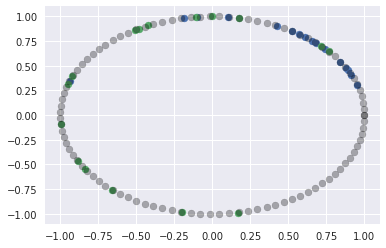

In [566]:
x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

plt.scatter(clust_vecs[:, 0], clust_vecs[:, 1], label="cluster")
plt.scatter(sprd_vecs[:, 0], sprd_vecs[:, 1], label="spread")
plt.scatter(enc[:, 0], enc[:, 1], color='k', alpha=0.3)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

## Normal Voja Baseline

In [567]:
all_vecs = np.concatenate((clust_vecs, sprd_vecs))
feed_vecs = list(all_vecs)

In [568]:
seed = 8

n_repeats = 3
t_pause = 0.4
t_present = 0.3
t_each = t_pause + t_present
n_neurons = 100

dt = 0.001

D = 2

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

intercepts = [0.3] * n_neurons

x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    pause = nengo.Node(lambda t: -feed.paused)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

    conn_in = nengo.Connection(in_nd, ens, learning_rule_type=nengo.Voja(5e-2))
    nengo.Connection(pause, conn_in.learning_rule, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_paused = nengo.Probe(pause, synapse=None)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.1)

In [569]:
with nengo.Simulator(model) as sim:
    #sim.run(0.2)
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:13.                                                 


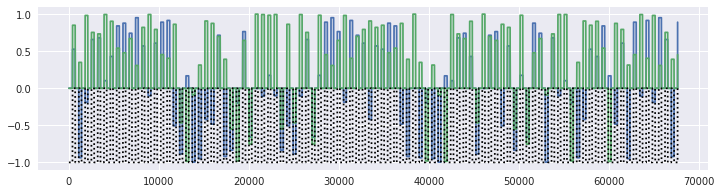

In [570]:
plt.figure(figsize=(12, 3))
plt.plot(sim.data[p_in])
plt.plot(sim.data[p_paused], color='k', linestyle=':')

(-1.1, 1.1)

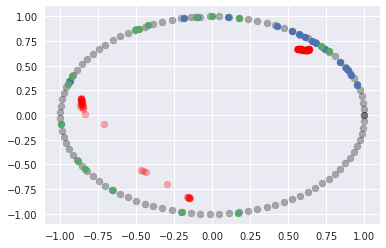

In [571]:
scale = (sim.data[ens].gain / ens.radius)[:, np.newaxis]
enc_hist = sim.data[p_enc]

init_enc = enc_hist[0].copy() / scale
fin_enc = enc_hist[-1].copy() / scale

plt.scatter(init_enc[:, 0], init_enc[:, 1], color='k', label="orig", alpha=0.3)
plt.scatter(fin_enc[:, 0], fin_enc[:, 1], color='r', label="final", alpha=0.3)

plt.scatter(clust_vecs[:, 0], clust_vecs[:, 1], label="cluster")
plt.scatter(sprd_vecs[:, 0], sprd_vecs[:, 1], label="spread")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [572]:
with nengo.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[-1], intercepts=intercepts)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [573]:
_, activity_clust = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=clust_vecs)
_, activity_sprd = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=sprd_vecs)

In [574]:
columns = ("vec", "resp")

a1 = activity_clust.flatten()
l1 = ["clust"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1)})


a2 = activity_sprd.flatten()
l2 = ["sprd"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2)})

acts = pd.concat((p1, p2))

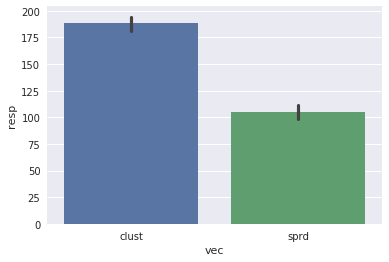

In [575]:
sns.barplot(x="vec", y="resp", data=acts)

## Add recurrent connections to see the effect

In [455]:
rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 2.5e4

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[-1], intercepts=intercepts)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)
    
    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:05.                                                 


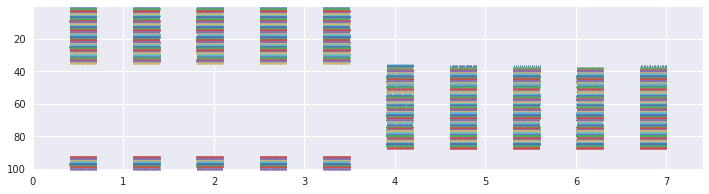

In [456]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

In [457]:
meg_sig = meg_from_spikes(sim.data[p_spikes])

In [458]:
clust_slc = slice(int(t_pause/dt), int(t_each/dt)*len(clust_vecs)+int(t_pause/dt))
sprd_slc = slice(clust_slc.stop, int(t_each/dt)*len(feed_vecs)+int(t_pause/dt))

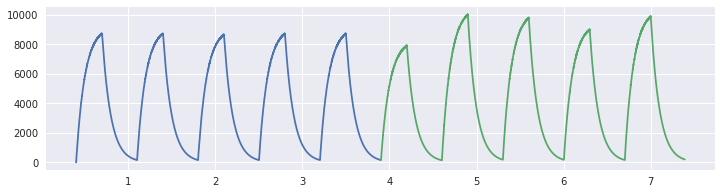

In [459]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[clust_slc], meg_sig[clust_slc])
plt.plot(sim.trange()[sprd_slc], meg_sig[sprd_slc])

## Voja with recurrent inihibitory connections

In [512]:
all_vecs = np.concatenate((clust_vecs, sprd_vecs))
feed_vecs = list(all_vecs)

In [523]:
seed = 8

n_repeats = 3
t_pause = 0.3
t_present = 0.3
t_each = t_pause + t_present
n_neurons = 100

D = 2

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

intercepts = [0.3] * n_neurons

rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 1e5

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    pause = nengo.Node(lambda t: -feed.paused)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)

    conn_in = nengo.Connection(in_nd, ens,learning_rule_type=nengo.Voja(5e-2))
    nengo.Connection(pause, conn_in.learning_rule, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_paused = nengo.Probe(pause, synapse=None)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.1)
    p_spikes = nengo.Probe(ens.neurons)

In [524]:
with nengo.Simulator(model) as sim:
    #sim.run(0.2)
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:13.                                                 


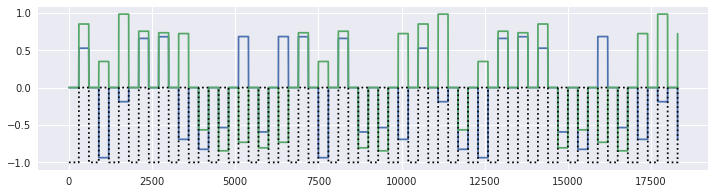

In [525]:
plt.figure(figsize=(12, 3))
plt.plot(sim.data[p_in])
plt.plot(sim.data[p_paused], color='k', linestyle=':')

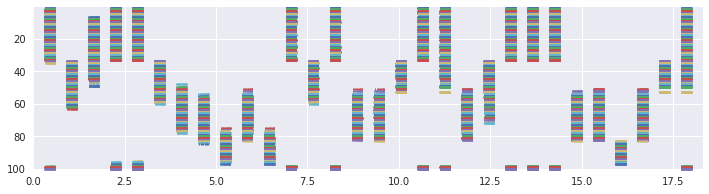

In [526]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

(-1.1, 1.1)

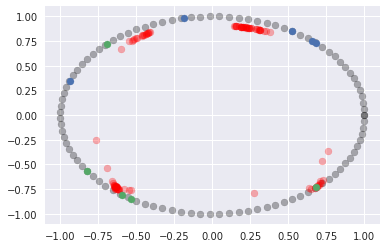

In [527]:
scale = (sim.data[ens].gain / ens.radius)[:, np.newaxis]
enc_hist = sim.data[p_enc]

init_enc = enc_hist[0].copy() / scale
fin_enc = enc_hist[-1].copy() / scale

plt.scatter(init_enc[:, 0], init_enc[:, 1], color='k', label="orig", alpha=0.3)
plt.scatter(fin_enc[:, 0], fin_enc[:, 1], color='r', label="final", alpha=0.3)

plt.scatter(clust_vecs[:, 0], clust_vecs[:, 1], label="cluster")
plt.scatter(sprd_vecs[:, 0], sprd_vecs[:, 1], label="spread")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [528]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[-1], intercepts=intercepts)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)
    
    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:03.                                                 


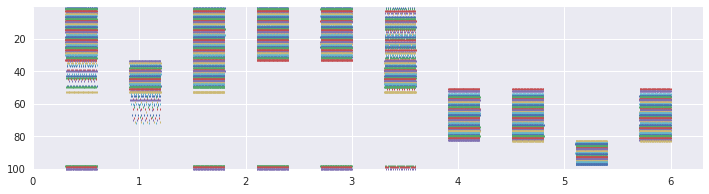

In [529]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

In [530]:
meg_sig = meg_from_spikes(sim.data[p_spikes])

In [531]:
clust_slc = slice(int(t_pause/dt), int(t_each/dt)*len(clust_vecs)+int(t_pause/dt))
sprd_slc = slice(clust_slc.stop, int(t_each/dt)*len(feed_vecs)+int(t_pause/dt))

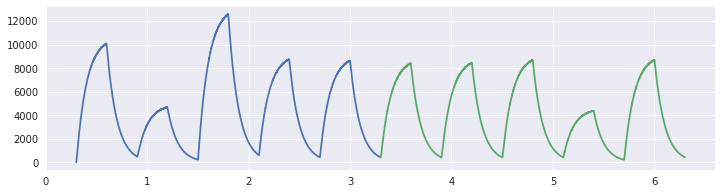

In [532]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[clust_slc], meg_sig[clust_slc])
plt.plot(sim.trange()[sprd_slc], meg_sig[sprd_slc])

## Negative Voja

In [ ]:
# make a model
# based off the reactions of the neurons, move the encoders towards the average of the last few activations

# Apply to full vocab

In [533]:
D = 32
n_neurons = 1000
seed = 8
n_items = 5

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [551]:
print("Fan1", np.linalg.norm(np.mean(fan1_pair_vecs, axis=0)))
print("Fan2", np.linalg.norm(np.mean(fan2_pair_vecs, axis=0)))
print("Fan2", np.linalg.norm(np.mean(fan2_pair_vecs+fan1_pair_vecs, axis=0)))

Fan1 0.3678823472348973
Fan2 0.715266222151445
Fan2 0.38311022420794705


In [535]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [434]:
seed = 8

n_repeats = 3
t_pause = 0.5
t_present = 0.3
t_each = t_pause + t_present

dt = 0.001

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)
intercepts = [0.3] * n_neurons

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    pause = nengo.Node(lambda t: -feed.paused)

    ens = nengo.Ensemble(n_neurons, D, intercepts=intercepts)

    conn_in = nengo.Connection(in_nd, ens, learning_rule_type=nengo.Voja(5e-2))
    nengo.Connection(pause, conn_in.learning_rule, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_paused = nengo.Probe(pause, synapse=None)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.1)

In [435]:
with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:53.                                                 


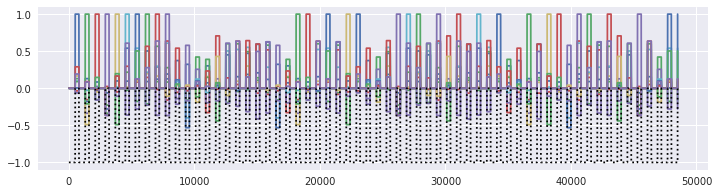

In [436]:
plt.figure(figsize=(12, 3))
plt.plot(spa.similarity(sim.data[p_in], fan1_pair_vecs+fan2_pair_vecs))
plt.plot(sim.data[p_paused], color='k', linestyle=':')

In [437]:
enc_hist = sim.data[p_enc]

with nengo.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[-1], intercepts=intercepts)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [438]:
_, activity_fan1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan1_pair_vecs))
_, activity_fan2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan2_pair_vecs))

In [439]:
columns = ("vec", "resp")

a1 = activity_fan1.flatten()
l1 = ["fan1"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1)})


a2 = activity_fan2.flatten()
l2 = ["fan2"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2)})

acts = pd.concat((p1, p2))

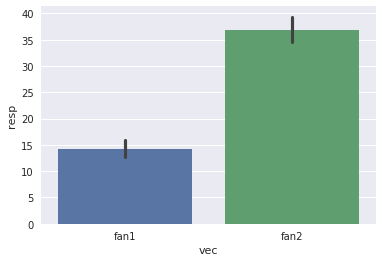

In [440]:
sns.barplot(x="vec", y="resp", data=acts)

## Add recurrent connections to see the effect

In [441]:
rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 2.5e4

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[-1], intercepts=intercepts)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)
    
    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:15.                                                 


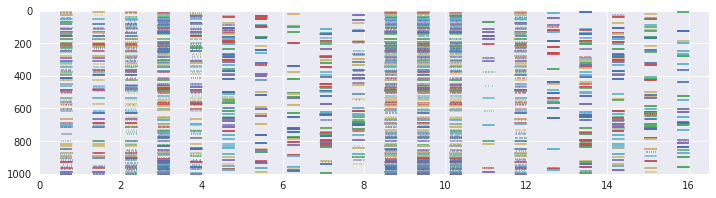

In [442]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

In [443]:
meg_sig = meg_from_spikes(sim.data[p_spikes])

In [444]:
fan1_slc = slice(int(t_pause/dt), int(t_each/dt)*len(fan1_pair_vecs)+int(t_pause/dt))
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+int(t_each/dt)*len(fan2_pair_vecs)+int(t_pause/dt))

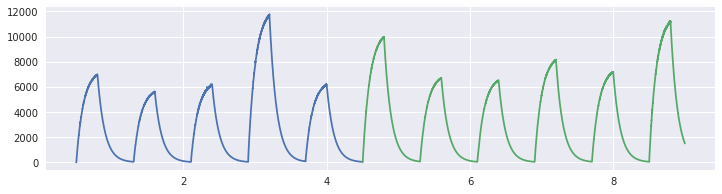

In [445]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[fan1_slc], meg_sig[fan1_slc])
plt.plot(sim.trange()[fan2_slc], meg_sig[fan2_slc])

## Voja with recurrent inihibitory connections

In [537]:
seed = 8

n_repeats = 3
t_pause = 0.5
t_present = 0.3
t_each = t_pause + t_present
n_neurons = 100

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

intercepts = [0.3] * n_neurons

rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 1e5

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    pause = nengo.Node(lambda t: -feed.paused)

    ens = nengo.Ensemble(n_neurons, D, intercepts=intercepts)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)

    conn_in = nengo.Connection(in_nd, ens,learning_rule_type=nengo.Voja(5e-2))
    nengo.Connection(pause, conn_in.learning_rule, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_paused = nengo.Probe(pause, synapse=None)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.1)
    p_spikes = nengo.Probe(ens.neurons)

In [538]:
with nengo.Simulator(model) as sim:
    #sim.run(0.2)
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:31.                                                 


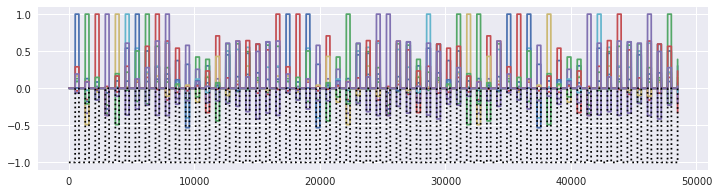

In [540]:
plt.figure(figsize=(12, 3))
plt.plot(spa.similarity(sim.data[p_in], fan1_pair_vecs+fan2_pair_vecs))
plt.plot(sim.data[p_paused], color='k', linestyle=':')

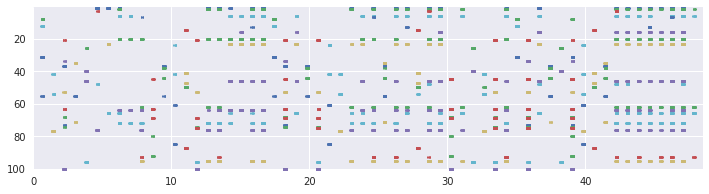

In [541]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

In [543]:
enc_hist = sim.data[p_enc].copy()
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, D, encoders=enc_hist[-1], intercepts=intercepts)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)
    
    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


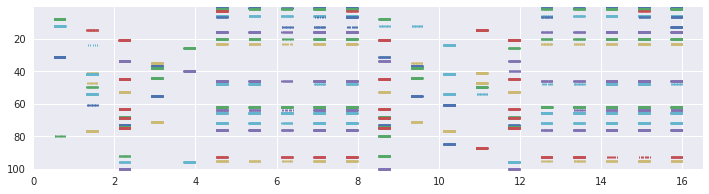

In [544]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

In [545]:
meg_sig = meg_from_spikes(sim.data[p_spikes])

In [547]:
fan1_slc = slice(int(t_pause/dt), int(t_each/dt)*len(fan1_pair_vecs)+int(t_pause/dt))
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+int(t_each/dt)*len(fan2_pair_vecs)+int(t_pause/dt))

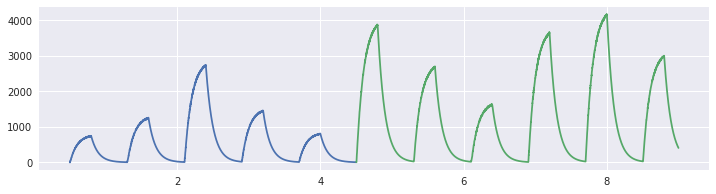

In [548]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[fan1_slc], meg_sig[fan1_slc])
plt.plot(sim.trange()[fan2_slc], meg_sig[fan2_slc])